### 준비할 데이터셋 ###
  
1) plant1_train 공장 데이터(훈련시에만 사용 <- tem_in_loc1,2,3 / hum_in_loc1,2,3)  
2) 기상 데이터( 서산 ASOS 데이터셋 <- 날씨마루에서 다운받을수 있음)

https://bd.kma.go.kr/kma2019/svc/intro/serviceInfo2.do?pageNum=5&menuCd=F030103000

In [1]:
import pandas as pd
from numpy import mean
from scipy import stats #scipy란 과학기술 통계분석함수 모음이다.
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothicCoding'
plt.rcParams['axes.unicode_minus'] = False
import mglearn 
import missingno as msno
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential,load_model
from keras.layers import Dense,Activation,LSTM,Dropout
from keras.optimizers import Adam
from IPython .display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import np_utils
from numpy import argmax

Using TensorFlow backend.


In [2]:
#plant1_train_with_weather는 서산 ASOS의 데이터셋과 plant1의 데이터셋을 '일시'에 맞춰서 동일한 '일시'일 경우 merge한 결과이다.
datanew=pd.read_csv('C:/Anaconda3/python/csvdata/hyundae/plant1_train_with_weather.csv')


In [3]:
del datanew['Unnamed: 0']

In [4]:
datanew['일시'] = pd.to_datetime(datanew['일시'], format='%Y-%m-%d %H:%M:%S', errors='raise')


In [5]:
datanew


,일시,tem_in_loc1,hum_in_loc1,tem_coil_loc1,tem_in_loc2,hum_in_loc2,tem_coil_loc2,tem_in_loc3,hum_in_loc3,tem_coil_loc3,...,cond_loc3,기온(°C),누적강수량(mm),풍향(deg),풍속(m/s),현지기압(hPa),해면기압(hPa),습도(%),일사(MJ/m^2),일조(Sec)
0,2016-09-01 03:00:00,25.32,64.04,25.59,23.25,71.06,24.37,22.48,73.05,24.14,...,0.0,17.4,0.0,293.2,0.4,994.8,998.1,97.6,0.0,0.0
1,2016-09-01 06:00:00,24.84,63.61,25.21,22.73,71.98,24.14,21.90,74.69,23.68,...,0.0,22.2,0.0,196.1,2.2,995.5,998.8,97.6,0.0,0.0
2,2016-09-02 03:00:00,26.88,59.80,26.85,25.05,65.23,25.55,23.83,70.24,24.87,...,0.0,22.4,0.0,110.2,0.6,1001.7,1005.0,97.6,0.0,0.0
3,2016-09-02 06:00:00,26.51,65.38,26.74,24.68,71.86,25.44,23.83,75.31,24.87,...,0.0,22.9,0.0,109.9,1.5,1002.8,1006.1,97.6,0.0,0.0
4,2016-09-02 09:00:00,26.58,61.97,26.77,26.18,60.47,25.78,25.08,63.64,25.51,...,0.0,24.5,0.0,152.3,1.8,1003.0,1006.3,83.5,1.4,5820.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54798,2019-03-31 23:10:00,10.52,36.39,10.52,10.55,35.20,11.17,9.85,37.88,9.79,...,0.0,3.1,0.0,314.6,2.6,1020.8,1024.1,57.8,22.3,36600.0
54799,2019-03-31 23:20:00,10.52,37.09,10.44,10.55,35.53,11.09,9.88,38.40,9.72,...,0.0,2.7,0.0,336.2,2.4,1020.9,1024.2,59.6,22.3,36600.0
54800,2019-03-31 23:30:00,10.43,37.18,10.56,10.49,35.65,11.21,9.85,38.22,9.91,...,0.0,3.1,0.0,289.8,2.7,1020.9,1024.2,59.2,22.3,36600.0
54801,2019-03-31 23:40:00,10.49,38.00,10.56,10.55,36.08,11.21,9.82,38.95,9.83,...,0.0,2.3,0.0,283.6,2.1,1020.9,1024.2,60.2,22.3,36600.0


In [6]:
#우린 기상데이터 : 기온(°C),누적강수량(mm),습도(%),일사(MJ/m^2),일조(Sec) 총 5개를 사용해서
#plant1의 loc1(보관장소1)의 습도를 예측하는 모델을 생성 할것이다.

In [7]:
datanew=datanew[['기온(°C)','풍속(m/s)','해면기압(hPa)','습도(%)','tem_in_loc1']]
datanew

,기온(°C),풍속(m/s),해면기압(hPa),습도(%),tem_in_loc1
0,17.4,0.4,998.1,97.6,25.32
1,22.2,2.2,998.8,97.6,24.84
2,22.4,0.6,1005.0,97.6,26.88
3,22.9,1.5,1006.1,97.6,26.51
4,24.5,1.8,1006.3,83.5,26.58
...,...,...,...,...,...
54798,3.1,2.6,1024.1,57.8,10.52
54799,2.7,2.4,1024.2,59.6,10.52
54800,3.1,2.7,1024.2,59.2,10.43
54801,2.3,2.1,1024.2,60.2,10.49


In [8]:
datanewori=datanew

In [9]:
datanewori[datanewori['기온(°C)']<0]

,기온(°C),풍속(m/s),해면기압(hPa),습도(%),tem_in_loc1
450,-0.3,0.1,1031.5,94.9,12.93
451,-1.5,0.0,1031.9,98.5,11.86
453,-0.3,1.2,1030.4,82.2,11.47
506,-0.8,1.4,1031.5,74.6,10.03
561,-1.1,0.0,1024.8,98.5,12.38
...,...,...,...,...,...
53695,-2.7,0.2,1023.8,94.0,9.54
53696,-1.6,0.0,1023.8,89.6,9.36
53697,-1.2,0.4,1024.0,87.3,9.30
53698,-0.5,0.1,1024.0,82.7,9.54


In [10]:
#데이터 이상치 제거
def outliers_iqr(data,i):
    q1, q3 = np.percentile(datanewori.iloc[:,i], [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    return np.where((datanewori.iloc[:,i] < upper_bound) & (datanewori.iloc[:,i] > lower_bound))


In [11]:
for i in range(datanewori.shape[1]):
    datanewori=datanewori.loc[outliers_iqr(datanewori,i)].reset_index(drop=True, inplace=False)

In [12]:
datanewori

,기온(°C),풍속(m/s),해면기압(hPa),습도(%),tem_in_loc1
0,17.4,0.4,998.1,97.6,25.32
1,22.2,2.2,998.8,97.6,24.84
2,22.4,0.6,1005.0,97.6,26.88
3,22.9,1.5,1006.1,97.6,26.51
4,24.5,1.8,1006.3,83.5,26.58
...,...,...,...,...,...
53641,3.1,2.6,1024.1,57.8,10.52
53642,2.7,2.4,1024.2,59.6,10.52
53643,3.1,2.7,1024.2,59.2,10.43
53644,2.3,2.1,1024.2,60.2,10.49


In [13]:
#이미 전처리는 완료했지만 설마모르니 결측치 제거
datanew=datanew.dropna(axis=0)

In [14]:
#dataframe의 모든 데이터들을 각 컬럼마다 정규화하는 함수
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator)




#https://blog.naver.com/PostView.nhn?blogId=gudrb1707&logNo=221275862122 참조함

In [15]:
datanew=datanewori

In [16]:
datanew=MinMaxScaler(datanew)

In [17]:
result=[]
for i in range(datanew.shape[0]):
    result.append(datanew.iloc[i,:].values) #행 데이터들을 묶음으로 리스트에 저장해줌
print(result)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [18]:
result

[array([0.621881  , 0.06896552, 0.15071283, 0.97472527, 0.71778258]),
 array([0.71401152, 0.37931034, 0.16496945, 0.97472527, 0.7062635 ]),
 array([0.71785029, 0.10344828, 0.29124236, 0.97472527, 0.75521958]),
 array([0.72744722, 0.25862069, 0.31364562, 0.97472527, 0.74634029]),
 array([0.75815739, 0.31034483, 0.31771894, 0.81978022, 0.74802016]),
 array([0.82917466, 0.46551724, 0.31364562, 0.66813187, 0.79409647]),
 array([0.82917466, 0.43103448, 0.299389  , 0.64395604, 0.81233501]),
 array([0.76775432, 0.20689655, 0.31364562, 0.81978022, 0.78521718]),
 array([0.7293666 , 0.27586207, 0.34215886, 0.88021978, 0.76985841]),
 array([0.71017274, 0.05172414, 0.34623218, 0.95824176, 0.77057835]),
 array([0.69673704, 0.24137931, 0.33604888, 0.97472527, 0.7662587 ]),
 array([0.68714012, 0.05172414, 0.35437882, 0.97472527, 0.75809935]),
 array([0.75431862, 0.37931034, 0.36863544, 0.85054945, 0.75449964]),
 array([0.80614203, 0.34482759, 0.36863544, 0.6989011 , 0.80441565]),
 array([0.81381958, 

In [19]:
result=np.array(result)

In [20]:
result.shape

(53646, 5)

In [32]:
row = int(round(result.shape[0]*0.9))


In [22]:
# 데이터 분리
# 훈련
train = result[0:int(len(result) * 0.5)]  
# 검증
val = result[int(len(result) * 0.5):int(len(result) * 0.75)]  
# 시험
test = result[int(len(result) * 0.75):-1]


In [23]:
x_train, y_train = train_test_split(train, random_state=0)
x_val, y_val = train_test_split(val, random_state=0)
x_test, y_test = train_test_split(test, random_state=0)

In [24]:
y_train.shape

(6706, 5)

In [25]:
# 훈련용 데이터/라벨 데이터셋 분류
x_train = train[:,:-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

In [33]:
# 테스트용 데이터/라벨 데이터셋 분류
x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
y_test = result[row:, -1]

In [34]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((26823, 4, 1), (5365, 4, 1), (26823,), (5365,))

In [35]:
# #딥러닝을 위한 모델 생성(이때는 습도를 측정하는 것이므로 LSTM을 사용한다.)
# # step 3. 모델생성
model2 = Sequential()
model2.add(LSTM(32, input_shape=(4,1), return_sequences=True)) 
model2.add(Dropout(0.2))
model2.add(LSTM(64, return_sequences=False))
model2.add(Dropout(0.7))
model2.add(Dense(1,activation='softsign'))
model2.compile('adam', 'mean_squared_error')
model2.summary()

# # 학습 모델 구성
# model = Sequential()  
# model.add(LSTM(32, batch_input_shape=(5, 4, 1), stateful=True, return_sequences=True))  
# model.add(Dropout(0.2)) # overfitting을 막기 위해 20% 가량을 drop  
# model.add(LSTM(32, batch_input_shape=(5, 4, 1), stateful=True))  
# model.add(Dropout(0.2))  
# model.add(Dense(1))

# # 학습 과정 설정
# model.compile(loss='mean_squared_error', optimizer='adam')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 4, 32)             4352      
_________________________________________________________________
dropout_5 (Dropout)          (None, 4, 32)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 29,249
Trainable params: 29,249
Non-trainable params: 0
_________________________________________________________________


In [36]:
hist=model2.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=256, epochs=100)

Train on 26823 samples, validate on 5365 samples
Epoch 1/100
26823/26823 [==============================] - 2s 60us/step - loss: 0.1017 - val_loss: 0.0829
Epoch 2/100
26823/26823 [==============================] - 1s 35us/step - loss: 0.0365 - val_loss: 0.0704
Epoch 3/100
26823/26823 [==============================] - 1s 37us/step - loss: 0.0259 - val_loss: 0.0406
Epoch 4/100
26823/26823 [==============================] - 1s 37us/step - loss: 0.0171 - val_loss: 0.0330
Epoch 5/100
26823/26823 [==============================] - 1s 35us/step - loss: 0.0144 - val_loss: 0.0253
Epoch 6/100
26823/26823 [==============================] - 1s 35us/step - loss: 0.0118 - val_loss: 0.0173
Epoch 7/100
26823/26823 [==============================] - 1s 35us/step - loss: 0.0100 - val_loss: 0.0138
Epoch 8/100
26823/26823 [==============================] - 1s 35us/step - loss: 0.0086 - val_loss: 0.0099
Epoch 9/100
26823/26823 [==============================] - 1s 39us/step - loss: 0.0074 - val_loss: 0.00

26823/26823 [==============================] - 1s 36us/step - loss: 0.0026 - val_loss: 0.0027
Epoch 78/100
26823/26823 [==============================] - 1s 34us/step - loss: 0.0027 - val_loss: 0.0029
Epoch 79/100
26823/26823 [==============================] - 1s 36us/step - loss: 0.0026 - val_loss: 0.0027
Epoch 80/100
26823/26823 [==============================] - 1s 36us/step - loss: 0.0026 - val_loss: 0.0028
Epoch 81/100
26823/26823 [==============================] - 1s 34us/step - loss: 0.0026 - val_loss: 0.0029
Epoch 82/100
26823/26823 [==============================] - 1s 42us/step - loss: 0.0026 - val_loss: 0.0026
Epoch 83/100
26823/26823 [==============================] - 1s 33us/step - loss: 0.0026 - val_loss: 0.0028
Epoch 84/100
26823/26823 [==============================] - 1s 33us/step - loss: 0.0026 - val_loss: 0.0026
Epoch 85/100
26823/26823 [==============================] - 1s 34us/step - loss: 0.0026 - val_loss: 0.0026
Epoch 86/100
26823/26823 [========================

In [37]:
pred2 = model2.predict(x_test)

In [38]:
datanewori['tem_in_loc1'].max()

37.08

NameError: name 'pred' is not defined

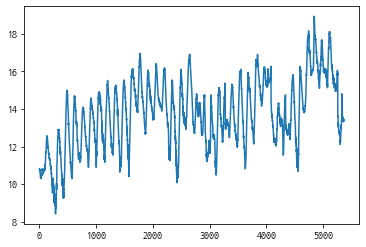

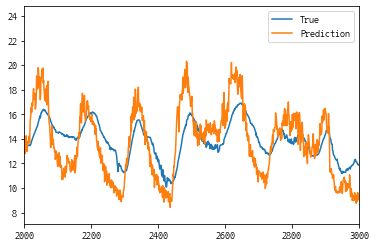

In [40]:
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(y_test*datanewori['tem_in_loc1'].max(), label='True')
ax.plot(pred2*datanewori['tem_in_loc1'].max(), label='Prediction')
ax.legend()
plt.xlim(2000,3000)
plt.show()

In [41]:
predmean=(pred+pred2)/2

NameError: name 'pred' is not defined

NameError: name 'predmean' is not defined

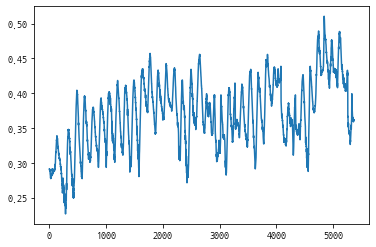

In [42]:
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(predmean, label='Prediction')
ax.legend()
plt.xlim(3000,4000)
plt.show()

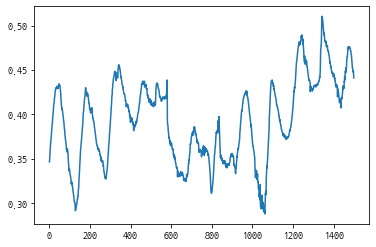

In [43]:
plt.plot(y_test[3500:5000])

KeyError: 'accuracy'

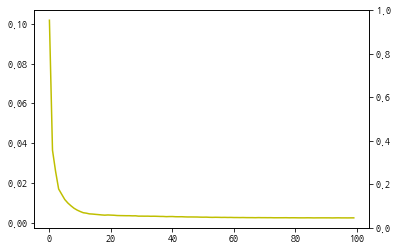

In [44]:
# step7. 모델학습 시각화
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'],'y',label='훈련 손실율')
acc_ax.plot(hist.history['accuracy'],'b',label='훈련 정확도')

loss_ax.set_xlabel("학습단계")
loss_ax.set_ylabel("손실율")
acc_ax.set_ylabel("정확도")

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
plt.xlim(0,10)

plt.show()